In [ ]:
# Проверяем видео карту
!nvidia-smi

Fri Jul 16 20:36:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Импорт библиотек

In [ ]:
# Подключаем гугл диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Для работы с данными
import pandas as pd
import numpy as np
import re

# Для визуализации данных 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Для обработки текстовых данных
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Для токенизации данных
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Для препроцессинга данных
from string import punctuation, digits

# Для построения модели нейронной сети
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Flatten, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import plot_model
from keras.optimizers import RMSprop

# Для игнорирования предупреждений
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4' 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
!ls '/content/drive/My Drive/datasets/NLP_datasets/Corona_NLP/'

Corona_NLP_test.csv  Corona_NLP_train.csv  model_LSTM


# Загрузка данных

In [ ]:
# Загрузим данные
PATH = '/content/drive/My Drive/datasets/NLP_datasets/Corona_NLP/'
test_df = pd.read_csv(PATH + 'Corona_NLP_test.csv')
train_df = pd.read_csv(PATH + 'Corona_NLP_train.csv', engine='python') # При ошибки чтения файла использовать engine

# Размерность данных
print(f'Train Data Shape: {train_df.shape}')
print(f'Test Data Shape: {test_df.shape}')

Train Data Shape: (41157, 6)
Test Data Shape: (3798, 6)


In [ ]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
# Функция для разбития данных
def get_label_split(ds):
  data = ds['OriginalTweet']
  label = ds['Sentiment']
  return data, label

train_data, train_label = get_label_split(train_df) 
test_data, test_label = get_label_split(test_df)

# Создаем датасеты
train = pd.DataFrame({'label': train_label, 'data': train_data}) 
test = pd.DataFrame({'label': test_label, 'data': test_data})

# Функция для извлечения меток
def get_label(x):
  if x == 'Extremely Positive' or x == 'Positive':
    return 1
  elif x == 'Extremely Negative' or x == 'Negative':
    return -1
  elif x == 'Neutral':
    return 0

train.label = train.label.apply(lambda x: get_label(x))
test.label = test.label.apply(lambda x: get_label(x))

# Препроцессинг данных

In [ ]:
# Функции для очистки и препроцесссинга данных
def get_revome(s):
  list_punctuation = list(punctuation)
  for i in list_punctuation:
    s = s.replace(i, '')
  return s.lower()

def get_clean(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence)
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', '', sentence)
    sentence = re.sub(r"\@(\w+)", '', sentence)
    sentence = re.sub(r"\#(\w+)", '', sentence)
    sentence = re.sub(r"\S(\w+)", '', sentence)
    sentence = sentence.replace("-", ' ')

    tokens = sentence.split()
    tokens = [get_revome(w) for w in tokens]

    stop_words = set(stopwords.words('english'))

    tokens = [w for w in tokens if not w in stop_words]

    remove_digits = str.maketrans('', '', digits)
    tokens = [w.translate(remove_digits) for w in tokens]
    tokens = [w.strip() for w in tokens]
    tokens = [w for w in tokens if w!=""]
    tokens = ' '.join(tokens)
    return tokens

# Очищем данные 
train.data = train.data.apply(lambda sentences: get_clean(sentences))
test.data = test.data.apply(lambda sentences: get_clean(sentences))

In [ ]:
# Функция для очистки от символа a
def get_del_a(sentences):
  sentences = sentences.replace('a', '')
  return sentences

train.data = train.data.apply(lambda sentences: get_del_a(sentences))
test.data = test.data.apply(lambda sentences: get_del_a(sentences))

In [ ]:
# Заменим отсутствующиеся значения в колонке data
train['data'].replace('', np.nan, inplace=True)
test['data'].replace('', np.nan, inplace=True)

# Удалим пропущенные значения
train.dropna(subset=['data'], inplace=True)
test.dropna(subset=['data'], inplace=True)

# Разделим на обучающую и тестовую выборку
train_data = train.data
train_label = train.label

test_data = test.data
test_label = test.label

# Визуализация данных

findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.


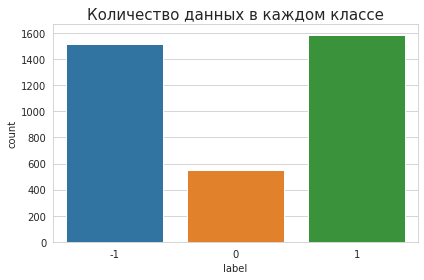

In [ ]:
# Гистограмма количество элементов в обучающей выборке

sns.countplot(x=train_label)
plt.title('Количество данных в каждом классе', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 15})
plt.tight_layout()
plt.show()

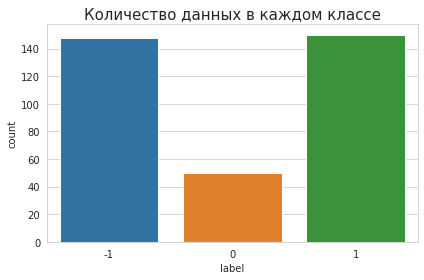

In [ ]:
# Гистограмма количество элементов в тестовой выборке

sns.countplot(x=test_label)
plt.title('Количество данных в каждом классе', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 15})
plt.tight_layout()
plt.show()

In [ ]:
# Преобразуем в категориальные данные

train_label = pd.get_dummies(train_label)
test_label = pd.get_dummies(test_label)

# Лемматизация текстовых данных

In [ ]:
lemmatizer = WordNetLemmatizer()

# Функция для преобразования тегов в wordnet тег
def get_convert_tag(teg):
  if teg.startswith('J'):
    return wordnet.ADJ
  elif teg.startswith('V'):
    return wordnet.VERB
  elif teg.startswith('N'):
    return wordnet.NOUN
  elif teg.startswith('R'):
    return wordnet.ADV
  else:
    return None

# Функция для поиска лем в каждом слове
def get_lem_sentences(sent):
  nltk_teg = nltk.pos_tag(nltk.word_tokenize(sent))
  wordnet_teg = map(lambda x: (x[0], get_convert_tag(x[1])), nltk_teg)
  lemmatized_sentence = []
  for word, tag in wordnet_teg:
    if tag is None:
      lemmatized_sentence.append(word)
    else:
      lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
  return ''.join(lemmatized_sentence)

# Произведем лемматизацию
train_lem = [get_lem_sentences(i) for i in train_data]
test_lem = [get_lem_sentences(i) for i in test_data]

# Токенизация

In [ ]:
samples_1 = train_lem
samples_2 = test_lem

tokenizer = Tokenizer(num_words = 25000)
tokenizer.fit_on_texts(samples_1)

train_data = tokenizer.texts_to_sequences(samples_1)
test_data = tokenizer.texts_to_sequences(samples_2)

word_index = tokenizer.word_index
print(f'Количество %s уникальных токенов' % len(word_index))

Количество 309 уникальных токенов


In [ ]:
# Конвертируем в тензор
maxlen = 40
train_data = preprocessing.sequence.pad_sequences(train_data, maxlen=maxlen, padding='post', truncating='post')
test_data = preprocessing.sequence.pad_sequences(test_data, maxlen=maxlen, padding='post', truncating='post')

# Создаём модель классификации Keras LSTM

In [ ]:
# Указываем параметры
embanding_dim = 32
vocab_inp_size = len(word_index) + 1
hiddden_size = 256

# Размерность данных
print(f'Train Data Shape: {train_data.shape}')
print(f'Test Data Shape: {test_data.shape}')

Train Data Shape: (3655, 40)
Test Data Shape: (348, 40)


In [ ]:
# Функция построения модели
def get_model():
  model = Sequential()
  # Для конвертации слов в вектор
  model.add(Embedding(input_dim = vocab_inp_size, output_dim=embanding_dim, input_length=maxlen))
  # Применим dropout воизбежания переобучения сети
  model.add(LSTM(hiddden_size, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))
  model.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
  model.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
  # Конвертируем 3D в 2D для добавления Dense слоя в модель
  model.add(Flatten())
  # model.add(GlobalMaxPooling1D())
  # Выходной слой с функцией активации
  model.add(Dense(3, activation='softmax'))
  model.summary()
  model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['categorical_accuracy'])

  return model

# Класс строит график всего обучения, состоявшего из нескольких этапов.
class LearnHistory:
    def __init__(self):
        self.history = {'loss':[], 'val_loss': []}

    def append(self, history):
        self.history['loss'].extend(history.history['loss'])
        self.history['val_loss'].extend(history.history['val_loss'])

    def plot(self, ylim=None):
        ep = [i+1 for i in range(len(self.history['loss']))]
        plt.plot(ep, self.history['loss'], label='Loss на обучающем наборе')
        plt.plot(ep, self.history['val_loss'], label='Loss на проверочном наборе')
        plt.ylabel('Средняя ошибка')
        plt.xlabel('Эпоха')
        if ylim is not None:
            plt.ylim(0, ylim)
        plt.title('История обучения')
        plt.grid()
        plt.legend()
        plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 32)            9920      
_________________________________________________________________
lstm (LSTM)                  (None, 40, 256)           295936    
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 128)           197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 40, 64)            49408     
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 7683      
Total params: 560,067
Trainable params: 560,067
Non-trainable params: 0
__________________________________________________

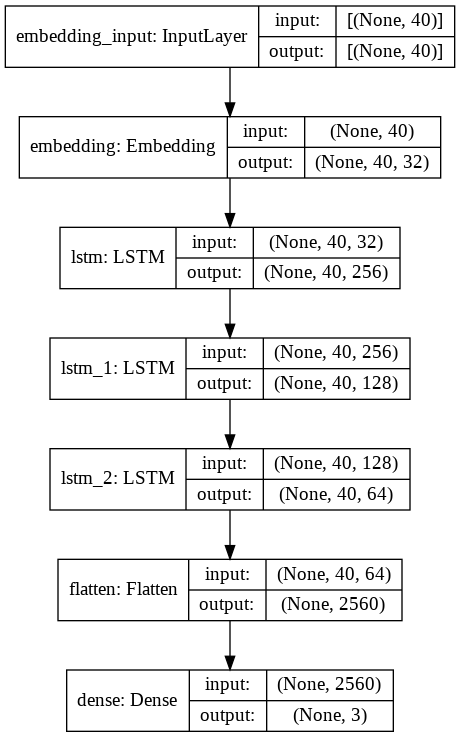

In [ ]:
model_LSTM = get_model()
lh = LearnHistory()
plot_model(model_LSTM, to_file='model.png', show_shapes=True) # и построим график для визуализации слоев и связей между ними

In [ ]:
history = model_LSTM.fit(train_data, train_label, epochs=10, batch_size=16, validation_split=0.2)


Epoch 1/10
183/183 [==============================] - 78s 384ms/step - loss: 0.6063 - categorical_accuracy: 0.4299 - val_loss: 0.6075 - val_categorical_accuracy: 0.3721
Epoch 2/10
183/183 [==============================] - 70s 384ms/step - loss: 0.6007 - categorical_accuracy: 0.4172 - val_loss: 0.5929 - val_categorical_accuracy: 0.4829
Epoch 3/10
183/183 [==============================] - 71s 389ms/step - loss: 0.5996 - categorical_accuracy: 0.4135 - val_loss: 0.5955 - val_categorical_accuracy: 0.4090
Epoch 4/10
183/183 [==============================] - 70s 382ms/step - loss: 0.5996 - categorical_accuracy: 0.4166 - val_loss: 0.6037 - val_categorical_accuracy: 0.3721
Epoch 5/10
183/183 [==============================] - 71s 388ms/step - loss: 0.5966 - categorical_accuracy: 0.4343 - val_loss: 0.6001 - val_categorical_accuracy: 0.3721
Epoch 6/10
183/183 [==============================] - 70s 384ms/step - loss: 0.5970 - categorical_accuracy: 0.4330 - val_loss: 0.6038 - val_categorical_acc

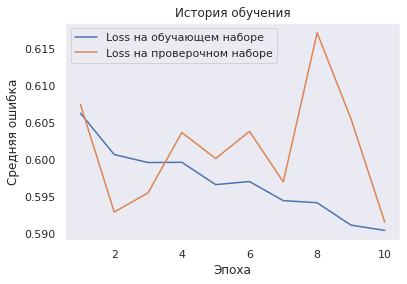

In [ ]:
# Граффик обучения
lh.append(history)
sns.set()
lh.plot()

In [ ]:
# Сохраним полученную модель
models.save_model(model_LSTM, PATH + 'model_LSTM.h5')

# Проверка модели на тестовой выборке

In [ ]:
# Загрузим модель 
model = models.load_model(PATH + 'model_LSTM.h5', compile=True)

# Предикт модели
prediction = model.predict(test_data)
print(f'\nModel predict: \n{prediction}\n')
# Предик вероятности
sent_pred = model.predict_proba(test_data)
print(f'\nModel predict_proba: \n{sent_pred}\n')

# Проверим оценку модели
model_LSTM.evaluate(test_data, test_label)


Model predict: 
[[0.4303124  0.11473428 0.45495328]
 [0.33730468 0.15598454 0.5067108 ]
 [0.25939906 0.09667948 0.6439215 ]
 ...
 [0.40553808 0.0957735  0.4986884 ]
 [0.34938186 0.06439728 0.58622086]
 [0.15626337 0.33425075 0.5094859 ]]


Model predict_proba: 
[[0.4303124  0.11473428 0.45495328]
 [0.33730468 0.15598454 0.5067108 ]
 [0.25939906 0.09667948 0.6439215 ]
 ...
 [0.40553808 0.0957735  0.4986884 ]
 [0.34938186 0.06439728 0.58622086]
 [0.15626337 0.33425075 0.5094859 ]]

11/11 [==============================] - 0s 36ms/step - loss: 0.5897 - categorical_accuracy: 0.4425


[0.5897010564804077, 0.44252872467041016]